In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
import astropy.io.fits as fits
from astropy.io import ascii
import math, os

#optional dependencies
from distutils.spawn import find_executable
if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)
    
from bsub import bsub

In [23]:
def reduce(dataf, flatf):
    """
    Bias-subtract and normalize science images
    """  
    flat = fits.getdata(flatf)
    dat = fits.getdata(dataf)
    hdr = fits.getheader(dataf)

    #Bias subtract
    datab = bsub(dat, hdr.get('cover')) 
    flatb = bsub(flat, hdr.get('cover')) 
    
    #Normalize
    flatb = flatb/np.median(flatb)
    reduced = datab/flatb
    
    return reduced

def plotImg(arr, **kwargs):
    """
    Plot 2D science image with identified objects
    """
    avg = np.mean(arr.flatten())
    std = np.std(arr.flatten())
    dim = arr.shape
    rng = kwargs.get('rng', [np.percentile(arr, 5), np.percentile(arr, 95)])
    
    fig, ax = plt.subplots(1)
    pl = plt.imshow(arr, origin='lower', interpolation='nearest', cmap='gray_r', \
                    vmin=rng[0], vmax=rng[1])
    
    if 'pts' in kwargs:
        pts = kwargs.get('pts')
        plt.scatter(pts[0], pts[1], marker='o', s=50, facecolors='none', edgecolors='r')

    plt.colorbar(pl).set_label('Detector Value (ADU)')
    plt.xlabel('pixels(x)')
    plt.ylabel('pixels(y)')
    plt.xlim(0, dim[0])
    plt.ylim(0, dim[1])
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()

In [21]:
def findStar(red, **kwargs):
    """
    Find all points in a 2D image with ADU counts above a percentile threshold
    """
    percentile = kwargs.get('percentile', 99)
    cut = np.percentile(red.flatten(), percentile)
    
    pts = []
    for row in range(red.shape[0]):
        idx = np.where(red[row] >= cut)[0]
        if len(idx) != 0:
            for col in idx:
                pts.append([row, col])
    pts = np.array(pts)
    
    return pts

def dist(r1, r2):
    """
    Return Euclidean distance between two 2D vectors
    """
    return np.sqrt((r1[0]-r2[0])**2 + (r1[1]-r2[1])**2)

In [19]:
def removePixels(pts, **kwargs):
    """
    Remove points associated with bad rows or columns of the detector
    """
    rows = kwargs.get('rows', [])
    cols = kwargs.get('cols', [])
    
    xpts, ypts = [], []
    for p in star_pts:
        if p[1] not in cols:
            xpts.append(p[0])
            ypts.append(p[1])
    pts = np.array([ypts, xpts])
    
    return pts.T

def clusterPoints(ptlist, **kwargs):
    
    radius = kwargs.get('radius', 20)
    
    clusters = []
    clus = []
    cpt = ptlist[0]
    for i in range(len(ptlist)):
        if dist(cpt, ptlist[i]) < radius**2:
            clus.append(ptlist[i])
        else:
            cpt = ptlist[i+1]
            clusters.append(np.array(clus))
            clus = []
            
    return clusters

def centroid():
    
    return none

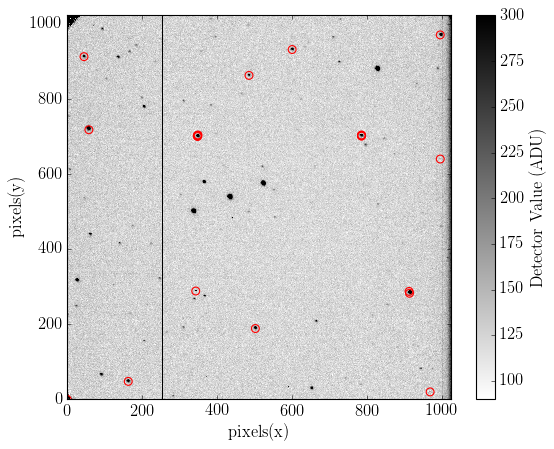

In [20]:
red = reduce('data/demo/d159.fits', 'data/demo/d121.fits')
star_pts = findStar(red, percentile=99.6)

bad_col = [255, 256] + list(np.arange(1000,1025))
ptlist = removePixels(star_pts, cols=bad_col)

clusters = clusterPoints(ptlist)

plotImg(red, pts=np.array([c[0] for c in np.array(clusters)]).T, rng=[90,300])